In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline



from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
EPOCHS = 50
BATCH_SIZE = 16
learning_rate = 1e-4

In [3]:
INPUT_SHAPE = (128,128)
INPUT_SHAPE_c = (128,128,3)

In [4]:
def generator(directory):
  image_datagen = ImageDataGenerator()
  mask_datagen = ImageDataGenerator()

  img_path = os.path.join(directory, "FLAIR MRI")
  image_generator = image_datagen.flow_from_directory(img_path, class_mode=None, color_mode='rgb', target_size=(128,128), batch_size=BATCH_SIZE, seed=1)

  mask_path = os.path.join(directory, "FLAIR MRI MASK")
  mask_generator = mask_datagen.flow_from_directory(mask_path, class_mode=None, color_mode='grayscale', target_size=(128,128), batch_size=BATCH_SIZE, seed=1)

  gen = zip(image_generator, mask_generator)

  for(img, mask) in gen:
    img = img/255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    yield (img,mask)

In [5]:
def conv2d_init_block(filters, input_shape=INPUT_SHAPE_c):
    input_ = Input(input_shape)
    conv = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(input_)
    act = Activation(activation='relu')(conv)
    conv = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(act)
    bn = BatchNormalization(axis=3)(conv)
    act = Activation(activation='relu')(bn)
    pool = MaxPooling2D(pool_size=(2, 2))(act)
    
    return conv, pool, input_

In [6]:
def conv2d_block(filters, prev, max_pool):
    
    conv = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(prev)
    act = Activation(activation='relu')(conv)
    conv = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(act)
    bn = BatchNormalization(axis=3)(conv)
    act = Activation(activation='relu')(bn)
    if max_pool == True:
        pool = MaxPooling2D(pool_size=(2, 2))(act)
        return conv, pool
        
    return conv, act

In [7]:
def concat_conv2d_block(filters, prev, concat_layer):
    concat = concatenate([Conv2DTranspose(filters=filters, kernel_size=(2, 2), strides=(2, 2), padding='same')(prev), concat_layer], axis=3)
    conv = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(concat)
    act = Activation(activation='relu')(conv)
    conv = Conv2D(filters=filters, kernel_size=(3, 3), padding='same')(act)
    bn = BatchNormalization(axis=3)(conv)
    act = Activation(activation='relu')(bn)
    
    return act

In [8]:
def unet_model(input_size=(128,128,3)):
    conv1, res1, input_ = conv2d_init_block(64, INPUT_SHAPE_c)
    conv2, res2 = conv2d_block(128, res1, True)
    conv3, res3 = conv2d_block(256, res2, True)
    conv4, res4 = conv2d_block(512, res3, True)
    conv5, res5 = conv2d_block(1024, res4, False)


    res6 = concat_conv2d_block(512, res5, conv4)
    res7 = concat_conv2d_block(256, res6, conv3)
    res8 = concat_conv2d_block(128, res7, conv2)
    res9 = concat_conv2d_block(64, res8, conv1)


    conv6 = Conv2D(filters=1, kernel_size=(1,1), activation='relu')(res9)
    model = Model(inputs=[input_], outputs=[conv6])

    return model


In [9]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def mean_iou(y_true, y_pred):
    y_pred = K.cast(K.greater(y_pred, .5), dtype='float32')
    inter = K.sum(K.sum(K.squeeze(y_true * y_pred, axis=3), axis=2), axis=1)
    union = K.sum(K.sum(K.squeeze(y_true + y_pred, axis=3), axis=2), axis=1) - inter
    return K.mean((inter + K.epsilon()) / (union + K.epsilon()))

In [10]:
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

In [11]:
train_generator = generator("Train")

validation_generator = generator("Test")

In [17]:
model = unet_model(input_size=(128,128, 3))
model.compile(optimizer=opt, loss=dice_loss, metrics=[mean_iou, dice_coef])


steps_per_epoch = 6286/BATCH_SIZE
validation_steps = 1572/BATCH_SIZE

#------------------------------------------
#ADD EARLY STOPPING
#------------------------------------------
es = EarlyStopping(monitor='val_dice_coef', mode="max", patience=5, min_delta=0.01, restore_best_weights=True)


callback = [ModelCheckpoint('checkpoint_save_128_3.hdf5', verbose=1, save_best_only=True)]

hist = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, callbacks=[es, callback], validation_data = validation_generator, validation_steps=validation_steps)

Epoch 1/50
393/392 [==============================] - ETA: 0s - loss: 0.3205 - mean_iou: 0.5564 - dice_coef: 0.6794WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0130s vs `on_test_batch_end` time: 0.0440s). Check your callbacks.

Epoch 00001: val_loss improved from inf to 0.38725, saving model to checkpoint_save_128_3.hdf5
393/392 [==============================] - 74s 188ms/step - loss: 0.3205 - mean_iou: 0.5564 - dice_coef: 0.6794 - val_loss: 0.3873 - val_mean_iou: 0.6136 - val_dice_coef: 0.6162
Epoch 2/50
393/392 [==============================] - ETA: 0s - loss: 0.2720 - mean_iou: 0.6110 - dice_coef: 0.7273
Epoch 00002: val_loss did not improve from 0.38725
393/392 [==============================] - 72s 182ms/step - loss: 0.2720 - mean_iou: 0.6110 - dice_coef: 0.7273 - val_loss: 0.3879 - val_mean_iou: 0.6086 - val_dice_coef: 0.6111
Epoch 3/50
393/392 [==============================] - ETA: 0s - loss: 0.2602 - mean_iou: 0.62

In [23]:
model.save('my_model_128_92.h5')

In [19]:
evaluation_generator = generator("Test/")
results = model.evaluate(evaluation_generator, steps=validation_steps)
print("Test lost: ",results[0])
print("Test Dice Coefficent: ",results[2])
print("Test  IoU: ",results[1])

Found 786 images belonging to 1 classes.
Found 786 images belonging to 1 classes.
99/98 [==============================] - 6s 59ms/step - loss: 0.0831 - mean_iou: 0.6826 - dice_coef: 0.9213
Test lost:  0.08309279382228851
Test Dice Coefficent:  0.9213075041770935
Test  IoU:  0.6826126575469971


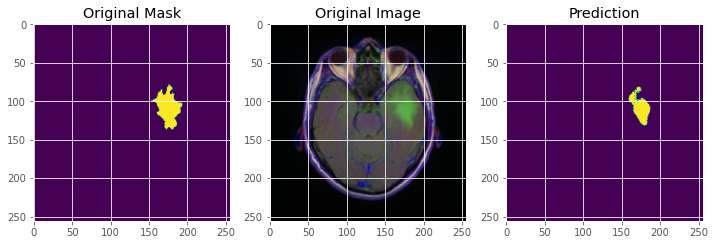

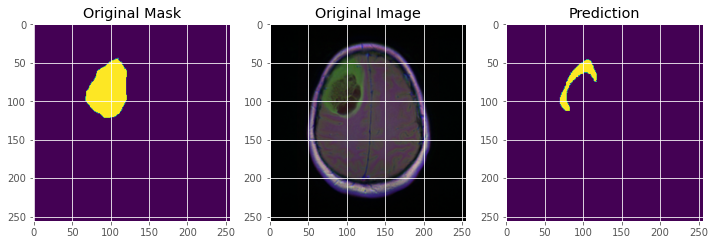

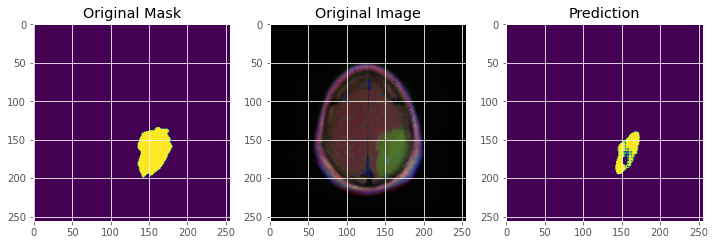

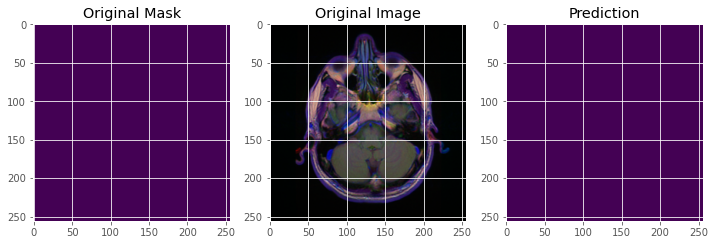

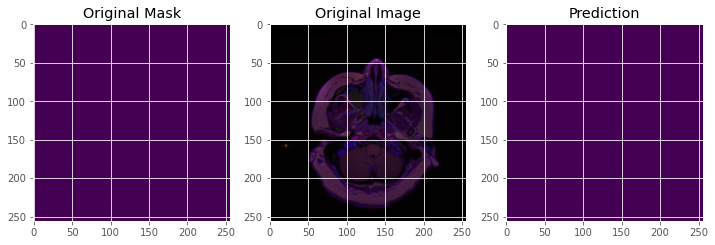

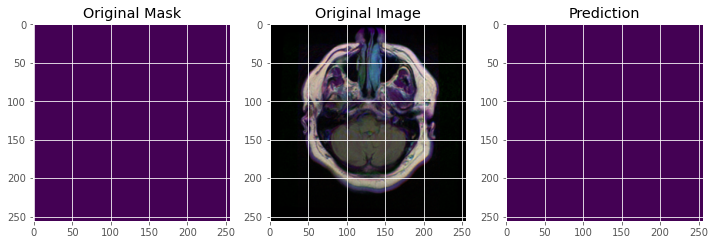

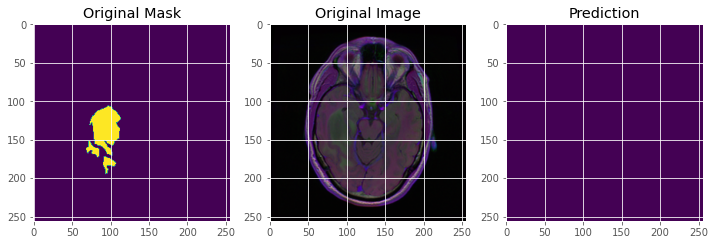

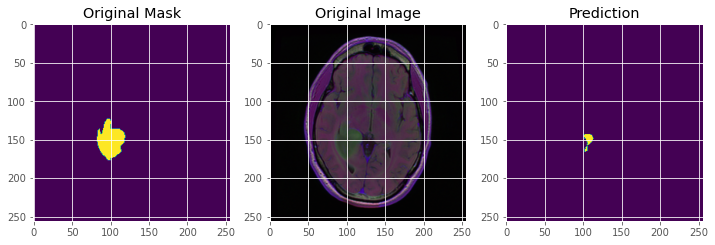

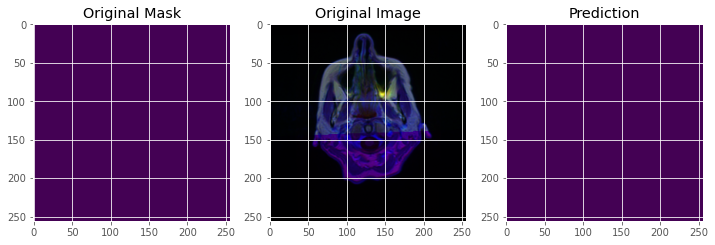

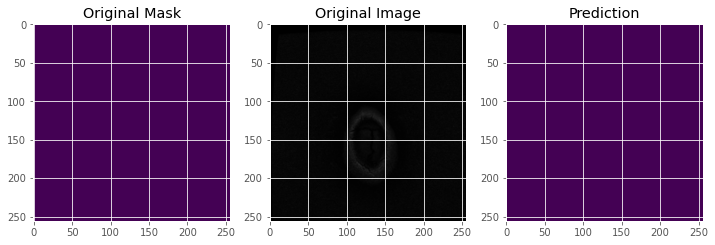

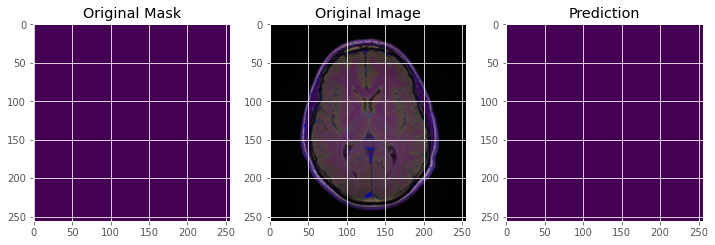

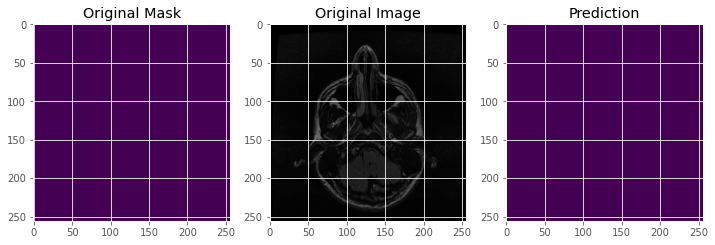

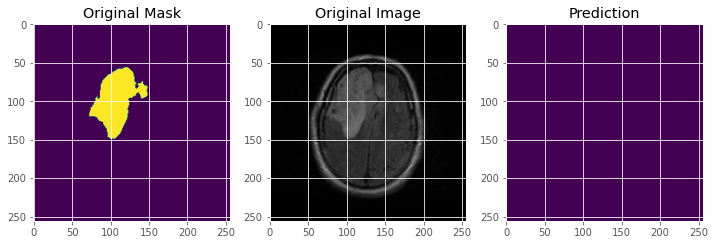

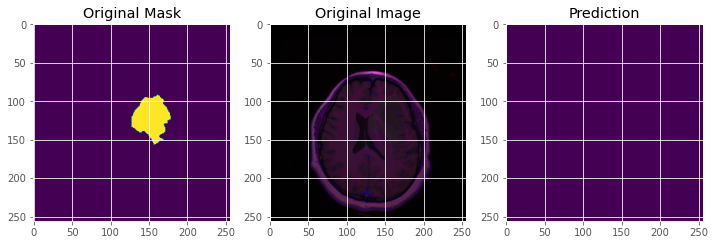

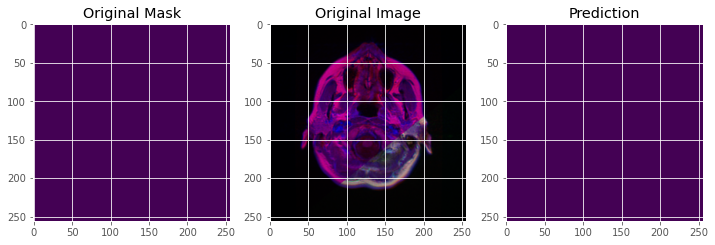

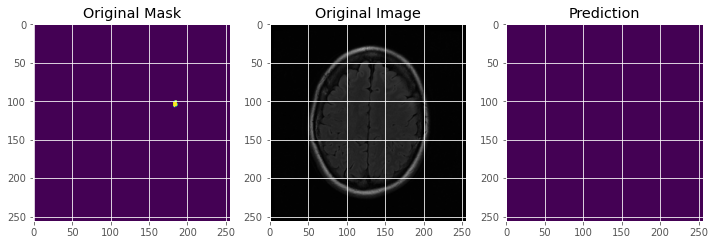

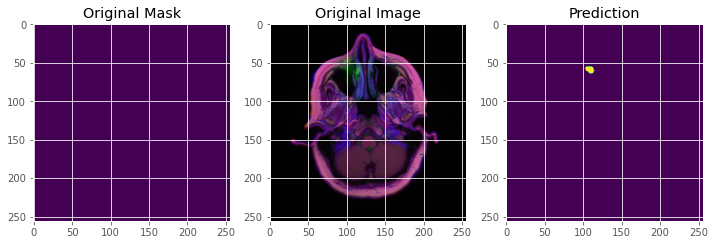

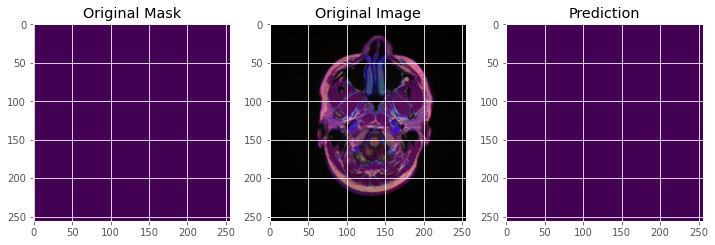

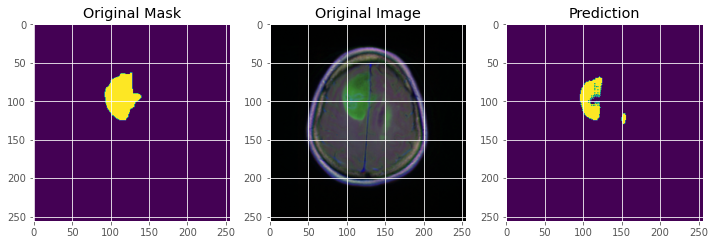

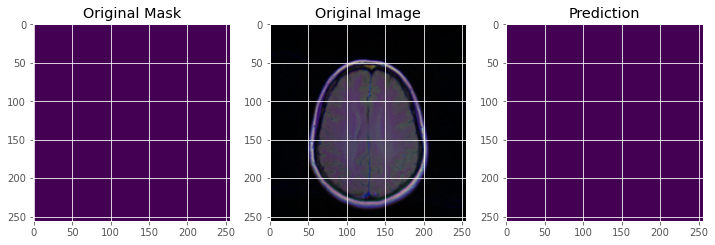

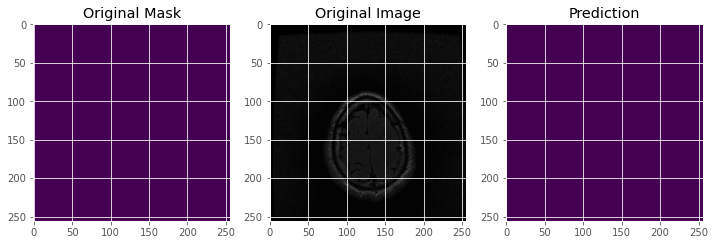

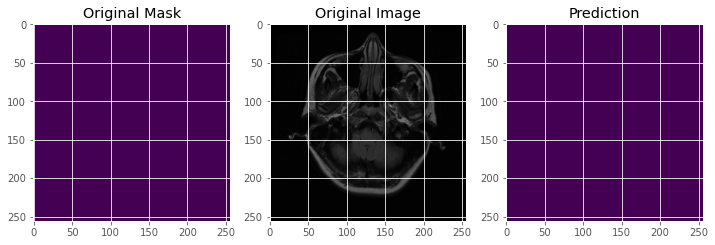

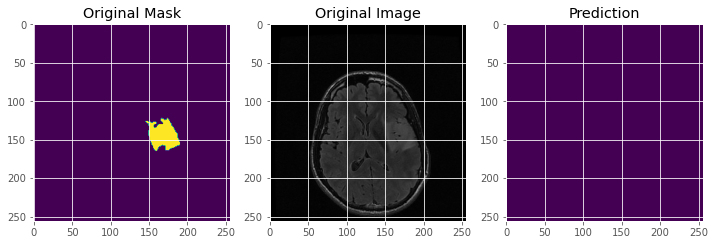

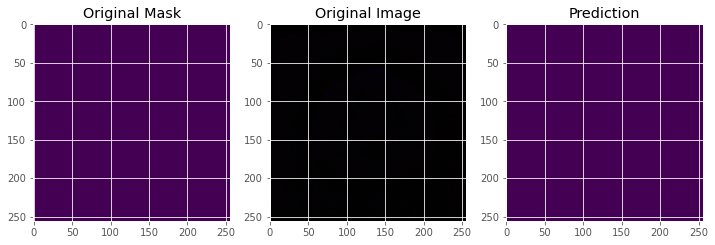

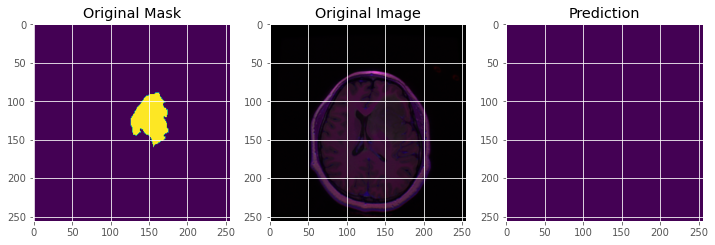

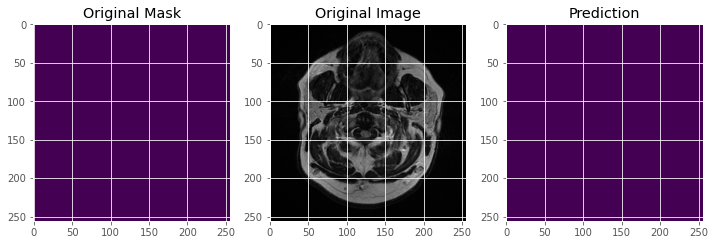

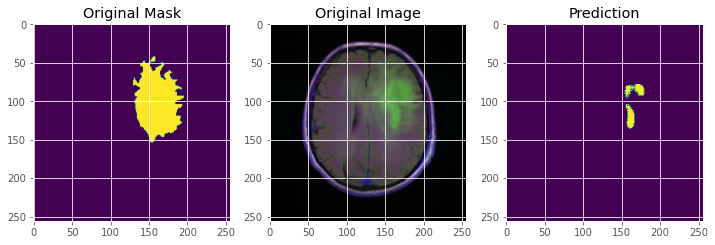

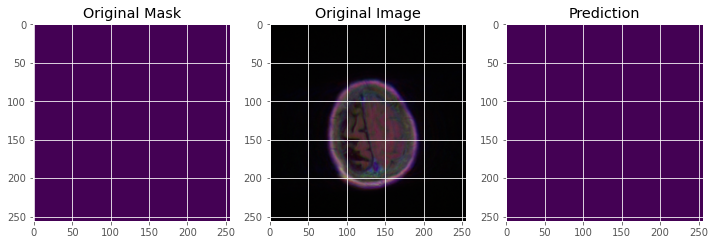

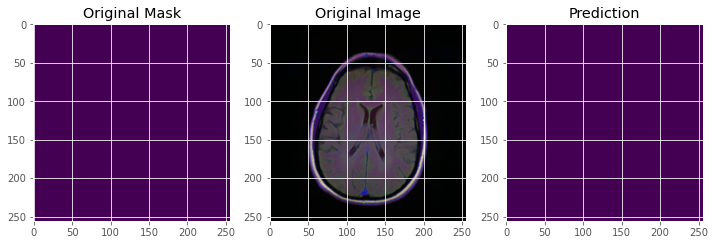

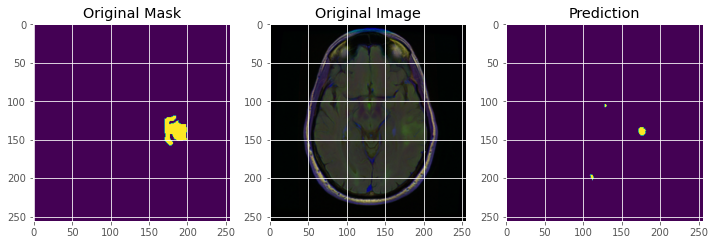

In [26]:
import PIL.Image as Image

for i in range(30):
    index = np.random.randint(3143,3929)
    img = Image.open(os.path.join('Test/FLAIR MRI/imgs/', str(index) + '.tif'))
    img = np.asarray(img)
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    mask = Image.open(os.path.join('Test/FLAIR MRI MASK/masks/', str(index) + '_mask.tif'))
    mask = np.asarray(mask)
    plt.imshow(np.squeeze(mask))
    plt.title('Original Mask')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()